In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Calculate moving averages
def moving_average(data, span):
    return data['Close'].ewm(span=span, adjust=False).mean()
    # return data['Close'].rolling(window=span).mean()

In [3]:
def calculate_rsi(data, window=14):
    delta = data['Close'].diff()

    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()

    rs = gain / loss

    rsi = 100 - (100 / (1 + rs))

    return rsi

In [4]:
def adx(data, window=14):

    # Calculate True Range
    data['tr0'] = abs(data['High'] - data['Low'])
    data['tr1'] = abs(data['High'] - data['Close'].shift())
    data['tr2'] = abs(data['Low'] - data['Close'].shift())
    data['TR'] = data[['tr0', 'tr1', 'tr2']].max(axis=1)

    # Calculate Directional Movement
    data['DMplus'] = np.where((data['High'] - data['High'].shift()) > (data['Low'].shift() - data['Low']), data['High'] - data['High'].shift(), 0)
    data['DMminus'] = np.where((data['Low'].shift() - data['Low']) > (data['High'] - data['High'].shift()), data['Low'].shift() - data['Low'], 0)

    # Calculate Smoothed True Range
    data['ATR'] = data['TR'].rolling(window=window).mean()

    # Calculate Smoothed Directional Movement
    data['ADMplus'] = data['DMplus'].rolling(window=window).mean()
    data['ADMminus'] = data['DMminus'].rolling(window=window).mean()

    # Calculate Directional Index
    data['DIplus'] = (data['ADMplus'] / data['ATR']) * 100
    data['DIminus'] = (data['ADMminus'] / data['ATR']) * 100

    data['DX'] = abs(data['DIplus'] - data['DIminus']) / (data['DIplus'] + data['DIminus']) * 100

    adx_values = data['DX'].rolling(window=window).mean()

    return (adx_values, data['DIplus'], data['DIminus'])

In [5]:
# Trading strategy combining moving average crossover, momentum, and VWAP
def trading_strategy(data, complete=False, rsi_window=None, overbought_threshold=None, oversold_threshold=None, adx_window=None, adx_threshold=None, short_window=None, long_window=None):
    signals = pd.DataFrame(index=data.index)
    signals['Date'] = pd.to_datetime(data['Date'])
    signals['signal'] = 0.0

        
    # Moving average crossover
    if short_window:
        signals['short_mavg'] = moving_average(data, short_window)
        signals['long_mavg'] = moving_average(data, long_window)
        signals['signal_ma'] = 0.0
        # Place buy order when short moving average crosses above long moving average
        signals.loc[(signals['short_mavg'].shift(1) < signals['long_mavg'].shift(1)) & (signals['short_mavg'] > signals['long_mavg']), 'signal_ma'] = 1.0

        # Place sell order when short moving average crosses below long moving average
        signals.loc[(signals['short_mavg'].shift(1) > signals['long_mavg'].shift(1)) & (signals['short_mavg'] < signals['long_mavg']), 'signal_ma'] = -1.0
        
    if rsi_window:
        rsi_values = calculate_rsi(data, window=rsi_window)
        signals['signal_rsi'] = 0.0
        signals['rsi'] = rsi_values
        signals.loc[signals['rsi'] > overbought_threshold, 'signal_rsi'] = -1.0
        signals.loc[signals['rsi'] < oversold_threshold, 'signal_rsi'] = 1.0

    if adx_window:
        adx_values = adx(data, window=adx_window)
        signals['signal_adx'] = 0.0
        signals['adx'] = adx_values[0]
        signals['+DI'] = adx_values[1]
        signals['-DI'] = adx_values[2]
        signals.loc[(signals['+DI'].shift(1) < signals['-DI'].shift(1)) & (signals['+DI'] > signals['-DI']) & (signals['adx'] > adx_threshold), 'signal_adx'] = 1.0
    
        # Place sell signal when -DI crosses over +DI and ADX is above the threshold
        signals.loc[(signals['+DI'].shift(1) > signals['-DI'].shift(1)) & (signals['+DI'] < signals['-DI']) & (signals['adx'] > adx_threshold), 'signal_adx'] = -1.0
        
        
    if complete:
        signals_sum = signals['signal_ma'] + signals['signal_rsi'] + signals['signal_adx']
        signals['sum'] = signals_sum
        signals['signal'] = 0.0
        signals.loc[signals['sum'] >= 2.0, 'signal'] = 1.0
        signals.loc[signals['sum'] <= -2.0, 'signal'] = -1.0
            
    elif short_window:
        signals['signal'] = signals['signal_ma']
    elif rsi_window:
        signals['signal'] = signals['signal_rsi']
    elif adx_window:
        signals['signal'] = signals['signal_adx']
    return signals

In [6]:
df = pd.read_csv("MSFT_hist.csv")
df = df[df['Date'] >= '2021-01-01']

In [7]:
signals = trading_strategy(df, short_window=20, long_window=70)
signals.to_csv("MSFT_signal_ma.csv")
signals = trading_strategy(df, adx_window=14, adx_threshold=25)
signals.to_csv("MSFT_signal_adx.csv")
signals = trading_strategy(df, rsi_window=14, overbought_threshold=70, oversold_threshold=50)
signals.to_csv("MSFT_signal_rsi.csv")
signals = trading_strategy(df, complete=True, short_window=10, long_window=11, adx_window=14, adx_threshold=25, rsi_window=14, overbought_threshold=70, oversold_threshold=50)
signals.to_csv("MSFT_complete_signal.csv")

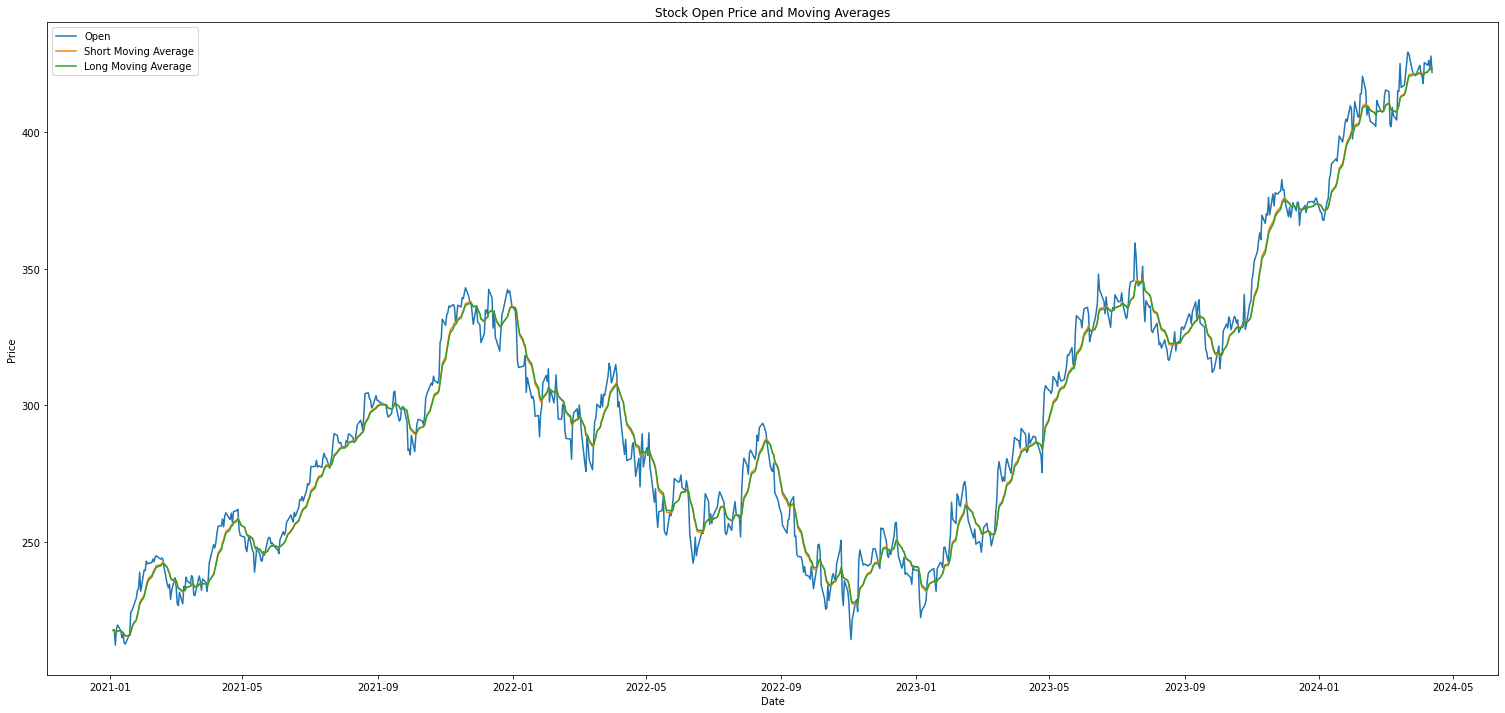

In [8]:
plt.figure(figsize=(26, 12))
plt.plot(signals['Date'].values, df['Close'].values, label='Open')
plt.plot(signals['Date'].values, signals['short_mavg'].values, label='Short Moving Average')
plt.plot(signals['Date'].values, signals['long_mavg'].values, label='Long Moving Average')
plt.title('Stock Open Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

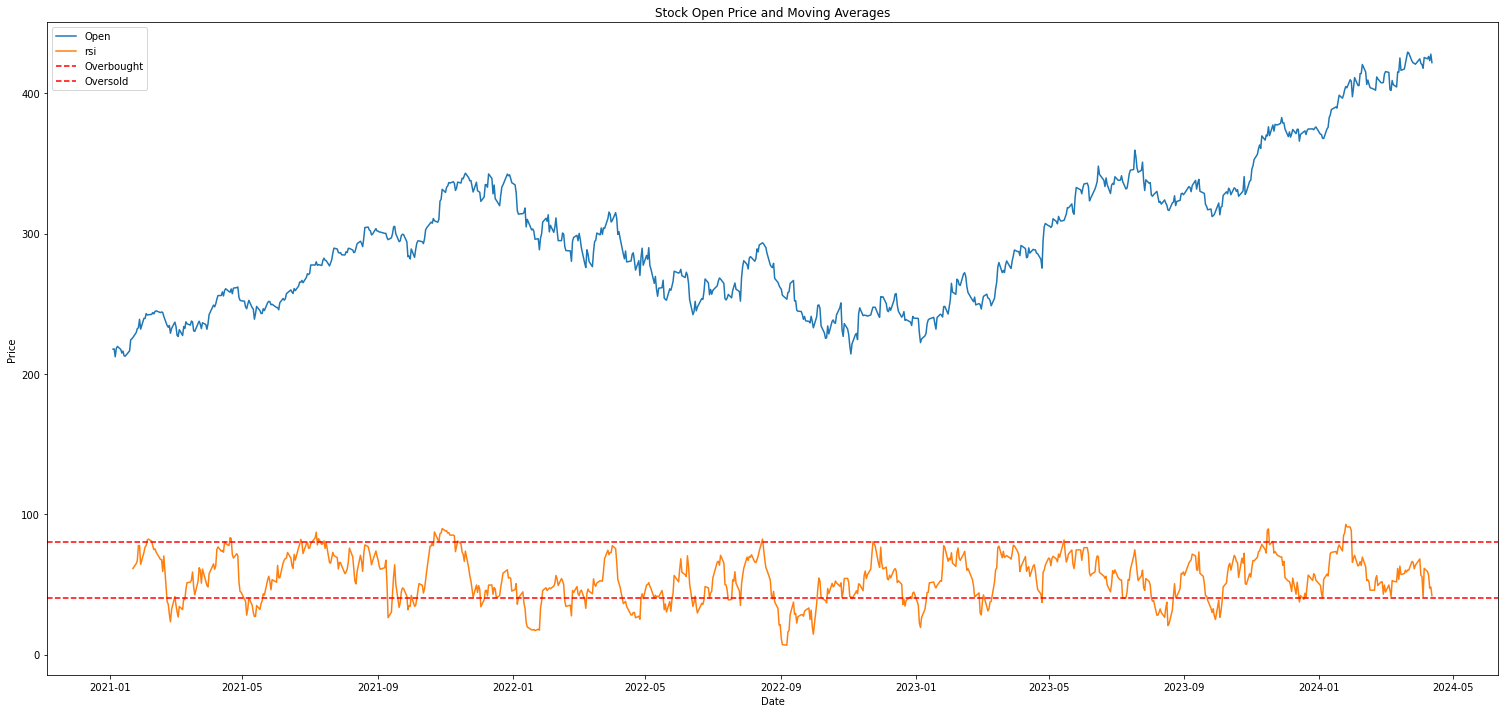

In [9]:
plt.figure(figsize=(26, 12))
plt.plot(signals['Date'].values, df['Close'].values, label='Open')
plt.plot(signals['Date'].values, signals['rsi'].values, label='rsi')
plt.axhline(y=80, color='r', linestyle='--', label='Overbought')
plt.axhline(y=40, color='r', linestyle='--', label='Oversold')
plt.title('Stock Open Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

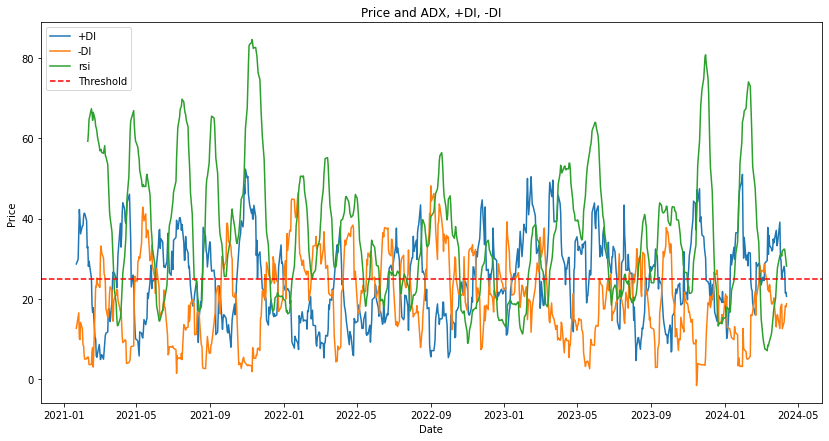

In [10]:
plt.figure(figsize=(14, 7))
plt.plot(signals['Date'].values, signals['+DI'].values, label='+DI')
plt.plot(signals['Date'].values, signals['-DI'].values, label='-DI')
plt.plot(signals['Date'].values, signals['adx'].values, label='rsi')
plt.axhline(y=25, color='r', linestyle='--', label='Threshold')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price and ADX, +DI, -DI')
plt.legend()
plt.show()

In [11]:
def backtest_strategy(data, initial_cash, transaction_cost, stop_loss, take_profit, **kwargs):
    signals = trading_strategy(data, **kwargs)

    # Initialize portfolio
    portfolio = pd.DataFrame(index=signals.index)
    portfolio['Cash'] = initial_cash
    portfolio['Position'] = 0.0
    portfolio['pnl'] = 0
    portfolio['g_sl'] = 0
    portfolio['g_tp'] = 0
    portfolio['close'] = 0
    portfolio['amount'] = 0
    portfolio['multiplier'] = 0
    portfolio['Cash'] = portfolio['Cash'].astype(float)
    portfolio['Position'] = portfolio['Position'].astype(float)
    portfolio['pnl'] = portfolio['pnl'].astype(float)
    portfolio['g_sl'] = portfolio['g_sl'].astype(float)
    portfolio['g_tp'] = portfolio['g_tp'].astype(float)
    portfolio['close'] = portfolio['close'].astype(float)
    portfolio['amount'] = portfolio['amount'].astype(float)
    portfolio['multiplier'] = portfolio['multiplier'].astype(float)
    global sl, tp, buy, sell, amount, pnl, no_trades, no_wins, multiplier
    sl = 0
    tp = 0
    buy = False
    sell = False
    pnl = 0
    amount = 0
    no_trades = 0
    no_wins = 0
    multiplier = 0
    
    cash_balance = initial_cash  # Initialize cash balance
    
    for index, row in signals.iterrows():
        signal = row['signal']
        price = data.loc[index, 'Close']
        stop_loss_price = price - (stop_loss * price)
        take_profit_price = price + (take_profit * price)
        
        
        if signal == 1.0 and cash_balance >= price * multiplier and tp == 0:
            # Buy
            amount = price
            multiplier = round(initial_cash/amount, 2)
            portfolio.loc[index, 'Position'] = 1.0
            cash_balance -= price * multiplier
            tp = take_profit_price
            sl = stop_loss_price
            buy = True
        elif signal == -1.0 and cash_balance >= price * multiplier and tp == 0:
            # Sell
            amount = price
            multiplier = round(initial_cash/amount, 2)
            portfolio.loc[index, 'Position'] = -1.0
            cash_balance -= price * multiplier
            tp = stop_loss_price
            sl = take_profit_price
            sell = True
        
        if price >= tp and buy:
            cash_balance += (amount*multiplier) + ((tp - amount)*multiplier)
            tp = 0
            sl = 0
            amount = 0
            buy = False
            no_trades += 1
            no_wins += 1
            multiplier = 0
        if price <= sl and buy:
            cash_balance += (amount*multiplier) + ((sl - amount)*multiplier)
            tp = 0
            sl = 0
            amount = 0
            buy = False
            no_trades += 1
            multiplier = 0
        if price <= tp and sell:
            cash_balance += (amount*multiplier) + ((amount - tp)*multiplier)
            tp = 0
            sl = 0
            amount = 0
            sell = False
            no_trades += 1
            no_wins += 1
            multiplier = 0
        if price >= sl and sell:
            cash_balance += (amount*multiplier) + ((amount - sl)*multiplier)
            tp = 0
            sl = 0
            amount = 0
            sell = False
            no_trades += 1
            multiplier = 0
            
        if index == signals.index[-1] and buy:
            cash_balance += (amount*multiplier) + ((price - amount)*multiplier)
        elif index == signals.index[-1] and sell:
            cash_balance += (amount*multiplier) + ((amount - price)*multiplier)
            
        pnl = cash_balance - initial_cash
        
        # Update portfolio value
        portfolio.loc[index, 'Cash'] = round(cash_balance, 2)
        portfolio.loc[index, 'amount'] = round(amount, 2)
        portfolio.loc[index, 'pnl'] = round(pnl, 2)
        portfolio.loc[index, 'g_sl'] = round(sl, 2)
        portfolio.loc[index, 'g_tp'] = round(tp, 2)
        portfolio.loc[index, 'close'] = round(price, 2)
        portfolio.loc[index, 'multiplier'] = round(multiplier, 2)
        portfolio.loc[index, 'no_trades'] = int(no_trades)
        portfolio.loc[index, 'no_wins'] = int(no_wins)

    sl = 0
    tp = 0
    pnl = 0
    amount = 0

    return portfolio

def win_percentage(portfolio):
    no_wins = portfolio.iloc[-1]['no_wins']
    no_trades = portfolio.iloc[-1]['no_trades']
    if no_trades == 0:
        return 0
    else:
        return round((no_wins / no_trades) * 100, 2)

In [12]:
def results(df):
    print("\nMoving Average:")
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, short_window=10, long_window=20, stop_loss=0.05, take_profit=0.2)
    print("Short-Window: 10, Long-Window: 20, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, short_window=10, long_window=30, stop_loss=0.05, take_profit=0.2)
    print("Short-Window: 10, Long-Window: 30, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, short_window=10, long_window=50, stop_loss=0.05, take_profit=0.2)
    print("Short-Window: 10, Long-Window: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, short_window=20, long_window=30, stop_loss=0.05, take_profit=0.2)
    print("Short-Window: 20, Long-Window: 30, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, short_window=20, long_window=50, stop_loss=0.05, take_profit=0.2)
    print("Short-Window: 20, Long-Window: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, short_window=20, long_window=70, stop_loss=0.05, take_profit=0.2)
    print("Short-Window: 20, Long-Window: 70, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, short_window=20, long_window=100, stop_loss=0.05, take_profit=0.2)
    print("Short-Window: 20, Long-Window: 100, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, short_window=30, long_window=100, stop_loss=0.05, take_profit=0.2)
    print("Short-Window: 30, Long-Window: 100, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, short_window=40, long_window=100, stop_loss=0.05, take_profit=0.2)
    print("Short-Window: 40, Long-Window: 100, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))

    print("\nADX:")
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, adx_window=4, adx_threshold=50, stop_loss=0.05, take_profit=0.2)
    print("ADX-Window: 4, ADX-Threshold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, adx_window=4, adx_threshold=75, stop_loss=0.05, take_profit=0.2)
    print("ADX-Window: 4, ADX-Threshold: 75, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, adx_window=6, adx_threshold=25, stop_loss=0.05, take_profit=0.2)
    print("ADX-Window: 6, ADX-Threshold: 25, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, adx_window=6, adx_threshold=50, stop_loss=0.05, take_profit=0.2)
    print("ADX-Window: 6, ADX-Threshold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, adx_window=6, adx_threshold=75, stop_loss=0.05, take_profit=0.2)
    print("ADX-Window: 6, ADX-Threshold: 75, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, adx_window=10, adx_threshold=25, stop_loss=0.05, take_profit=0.2)
    print("ADX-Window: 10, ADX-Threshold: 25, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, adx_window=10, adx_threshold=50, stop_loss=0.05, take_profit=0.2)
    print("ADX-Window: 10, ADX-Threshold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, adx_window=10, adx_threshold=75, stop_loss=0.05, take_profit=0.2)
    print("ADX-Window: 10, ADX-Threshold: 75, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, adx_window=14, adx_threshold=25, stop_loss=0.05, take_profit=0.2)
    print("ADX-Window: 14, ADX-Threshold: 25, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, adx_window=14, adx_threshold=50, stop_loss=0.05, take_profit=0.2)
    print("ADX-Window: 14, ADX-Threshold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, adx_window=14, adx_threshold=75, stop_loss=0.05, take_profit=0.2)
    print("ADX-Window: 14, ADX-Threshold: 75, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, adx_window=18, adx_threshold=25, stop_loss=0.05, take_profit=0.2)
    print("ADX-Window: 18, ADX-Threshold: 25, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, adx_window=18, adx_threshold=50, stop_loss=0.05, take_profit=0.2)
    print("ADX-Window: 18, ADX-Threshold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, adx_window=18, adx_threshold=75, stop_loss=0.05, take_profit=0.2)
    print("ADX-Window: 18, ADX-Threshold: 75, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))

    print("\nRSI:")
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=10, overbought_threshold=70, oversold_threshold=40, stop_loss=0.05, take_profit=0.2)
    print("RSI-Window: 10, Overbought: 70, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=10, overbought_threshold=80, oversold_threshold=40, stop_loss=0.05, take_profit=0.2)
    print("RSI-Window: 10, Overbought: 80, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=10, overbought_threshold=90, oversold_threshold=40, stop_loss=0.05, take_profit=0.2)
    print("RSI-Window: 10, Overbought: 90, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=10, overbought_threshold=70, oversold_threshold=50, stop_loss=0.05, take_profit=0.2)
    print("RSI-Window: 10, Overbought: 70, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=10, overbought_threshold=80, oversold_threshold=50, stop_loss=0.05, take_profit=0.2)
    print("RSI-Window: 10, Overbought: 80, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=10, overbought_threshold=90, oversold_threshold=50, stop_loss=0.05, take_profit=0.2)
    print("RSI-Window: 10, Overbought: 90, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=10, overbought_threshold=70, oversold_threshold=60, stop_loss=0.05, take_profit=0.2)
    print("RSI-Window: 10, Overbought: 70, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=10, overbought_threshold=80, oversold_threshold=60, stop_loss=0.05, take_profit=0.2)
    print("RSI-Window: 10, Overbought: 80, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=10, overbought_threshold=90, oversold_threshold=60, stop_loss=0.05, take_profit=0.2)
    print("RSI-Window: 10, Overbought: 90, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))

    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=14, overbought_threshold=70, oversold_threshold=40, stop_loss=0.05, take_profit=0.2)
    print("RSI-Window: 14, Overbought: 70, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=14, overbought_threshold=80, oversold_threshold=40, stop_loss=0.05, take_profit=0.2)
    print("RSI-Window: 14, Overbought: 80, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=14, overbought_threshold=90, oversold_threshold=40, stop_loss=0.05, take_profit=0.2)
    print("RSI-Window: 14, Overbought: 90, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=14, overbought_threshold=70, oversold_threshold=50, stop_loss=0.05, take_profit=0.2)
    print("RSI-Window: 14, Overbought: 70, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=14, overbought_threshold=80, oversold_threshold=50, stop_loss=0.05, take_profit=0.2)
    print("RSI-Window: 14, Overbought: 80, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=14, overbought_threshold=90, oversold_threshold=50, stop_loss=0.05, take_profit=0.2)
    print("RSI-Window: 14, Overbought: 90, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=14, overbought_threshold=70, oversold_threshold=60, stop_loss=0.05, take_profit=0.2)
    print("RSI-Window: 14, Overbought: 70, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=14, overbought_threshold=80, oversold_threshold=60, stop_loss=0.05, take_profit=0.2)
    print("RSI-Window: 14, Overbought: 80, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=14, overbought_threshold=90, oversold_threshold=60, stop_loss=0.05, take_profit=0.2)
    print("RSI-Window: 14, Overbought: 90, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))

    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=18, overbought_threshold=70, oversold_threshold=40, stop_loss=0.05, take_profit=0.2)
    print("RSI-Window: 18, Overbought: 70, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=18, overbought_threshold=80, oversold_threshold=40, stop_loss=0.05, take_profit=0.2)
    print("RSI-Window: 18, Overbought: 80, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=18, overbought_threshold=90, oversold_threshold=40, stop_loss=0.05, take_profit=0.2)
    print("RSI-Window: 18, Overbought: 90, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=18, overbought_threshold=70, oversold_threshold=50, stop_loss=0.05, take_profit=0.2)
    print("RSI-Window: 18, Overbought: 70, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=18, overbought_threshold=80, oversold_threshold=50, stop_loss=0.05, take_profit=0.2)
    print("RSI-Window: 18, Overbought: 80, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=18, overbought_threshold=90, oversold_threshold=50, stop_loss=0.05, take_profit=0.2)
    print("RSI-Window: 18, Overbought: 90, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=18, overbought_threshold=70, oversold_threshold=60, stop_loss=0.05, take_profit=0.2)
    print("RSI-Window: 18, Overbought: 70, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=18, overbought_threshold=80, oversold_threshold=60, stop_loss=0.05, take_profit=0.2)
    print("RSI-Window: 18, Overbought: 80, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=18, overbought_threshold=90, oversold_threshold=60, stop_loss=0.05, take_profit=0.2)
    print("RSI-Window: 18, Overbought: 90, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=26, overbought_threshold=90, oversold_threshold=60, stop_loss=0.05, take_profit=0.2)
    print("RSI-Window: 26, Overbought: 90, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=100, overbought_threshold=90, oversold_threshold=60, stop_loss=0.05, take_profit=0.2)
    print("RSI-Window: 100, Overbought: 90, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))

    print("\nComplete:")
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, complete=True, short_window=5, long_window=10, adx_window=14, adx_threshold=25, rsi_window=70, overbought_threshold=70, oversold_threshold=60, stop_loss=0.05, take_profit=0.2)
    print("Complete Fast, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio.to_csv("portfolio.csv")
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, complete=True, short_window=10, long_window=30, adx_window=22, adx_threshold=25, rsi_window=70, overbought_threshold=80, oversold_threshold=60, stop_loss=0.05, take_profit=0.2)
    print("Complete Normal, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, complete=True, short_window=10, long_window=30, adx_window=30, adx_threshold=25, rsi_window=70, overbought_threshold=80, oversold_threshold=50, stop_loss=0.05, take_profit=0.2)
    print("Complete Slow, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",win_percentage(portfolio))


In [13]:
# Microsoft
df = pd.read_csv("MSFT_hist.csv")
df = df[df['Date'] >= '2015-01-01']
print("Microsoft")
results(df)

Microsoft

Moving Average:
Short-Window: 10, Long-Window: 20, Total Profit/Loss: -100.16 , No-Trades: 23.0  Win%: 26.09
Short-Window: 10, Long-Window: 30, Total Profit/Loss: -54.95 , No-Trades: 23.0  Win%: 39.13
Short-Window: 10, Long-Window: 50, Total Profit/Loss: -14.53 , No-Trades: 23.0  Win%: 43.48
Short-Window: 20, Long-Window: 30, Total Profit/Loss: -40.04 , No-Trades: 22.0  Win%: 45.45
Short-Window: 20, Long-Window: 50, Total Profit/Loss: 5.24 , No-Trades: 17.0  Win%: 52.94
Short-Window: 20, Long-Window: 70, Total Profit/Loss: 20.06 , No-Trades: 15.0  Win%: 53.33
Short-Window: 20, Long-Window: 100, Total Profit/Loss: -9.82 , No-Trades: 11.0  Win%: 54.55
Short-Window: 30, Long-Window: 100, Total Profit/Loss: -19.95 , No-Trades: 11.0  Win%: 45.45
Short-Window: 40, Long-Window: 100, Total Profit/Loss: -19.91 , No-Trades: 7.0  Win%: 42.86

ADX:
ADX-Window: 4, ADX-Threshold: 50, Total Profit/Loss: -56.11 , No-Trades: 27.0  Win%: 48.15
ADX-Window: 4, ADX-Threshold: 75, Total Profit/Lo

In [14]:
# Apple
df = pd.read_csv("AAPL_hist.csv")
df = df[df['Date'] >= '2015-01-01']
print("Apple")
results(df)

Apple

Moving Average:
Short-Window: 10, Long-Window: 20, Total Profit/Loss: 105.03 , No-Trades: 36.0  Win%: 50.0
Short-Window: 10, Long-Window: 30, Total Profit/Loss: 75.0 , No-Trades: 31.0  Win%: 54.84
Short-Window: 10, Long-Window: 50, Total Profit/Loss: -29.85 , No-Trades: 29.0  Win%: 44.83
Short-Window: 20, Long-Window: 30, Total Profit/Loss: -5.01 , No-Trades: 29.0  Win%: 48.28
Short-Window: 20, Long-Window: 50, Total Profit/Loss: -104.92 , No-Trades: 16.0  Win%: 31.25
Short-Window: 20, Long-Window: 70, Total Profit/Loss: -14.93 , No-Trades: 20.0  Win%: 50.0
Short-Window: 20, Long-Window: 100, Total Profit/Loss: -45.13 , No-Trades: 19.0  Win%: 42.11
Short-Window: 30, Long-Window: 100, Total Profit/Loss: -63.27 , No-Trades: 15.0  Win%: 40.0
Short-Window: 40, Long-Window: 100, Total Profit/Loss: 22.99 , No-Trades: 12.0  Win%: 58.33

ADX:
ADX-Window: 4, ADX-Threshold: 50, Total Profit/Loss: -22.36 , No-Trades: 47.0  Win%: 44.68
ADX-Window: 4, ADX-Threshold: 75, Total Profit/Loss: -1

In [15]:
# JP Morgan
df = pd.read_csv("JPM_hist.csv")
df = df[df['Date'] >= '2015-01-01']
print("JP Morgan")
results(df)

JP Morgan

Moving Average:
Short-Window: 10, Long-Window: 20, Total Profit/Loss: -4.73 , No-Trades: 24.0  Win%: 41.67
Short-Window: 10, Long-Window: 30, Total Profit/Loss: 50.22 , No-Trades: 21.0  Win%: 52.38
Short-Window: 10, Long-Window: 50, Total Profit/Loss: 85.1 , No-Trades: 22.0  Win%: 54.55
Short-Window: 20, Long-Window: 30, Total Profit/Loss: 85.36 , No-Trades: 17.0  Win%: 64.71
Short-Window: 20, Long-Window: 50, Total Profit/Loss: -10.12 , No-Trades: 16.0  Win%: 43.75
Short-Window: 20, Long-Window: 70, Total Profit/Loss: -5.02 , No-Trades: 17.0  Win%: 47.06
Short-Window: 20, Long-Window: 100, Total Profit/Loss: -45.09 , No-Trades: 13.0  Win%: 38.46
Short-Window: 30, Long-Window: 100, Total Profit/Loss: 20.2 , No-Trades: 11.0  Win%: 54.55
Short-Window: 40, Long-Window: 100, Total Profit/Loss: 4.93 , No-Trades: 13.0  Win%: 53.85

ADX:
ADX-Window: 4, ADX-Threshold: 50, Total Profit/Loss: 53.7 , No-Trades: 31.0  Win%: 54.84
ADX-Window: 4, ADX-Threshold: 75, Total Profit/Loss: -21.

In [16]:
# Bank of America
df = pd.read_csv("BAC_hist.csv")
df = df[df['Date'] >= '2015-01-01']
print("Bank of America")
results(df)

Bank of America

Moving Average:
Short-Window: 10, Long-Window: 20, Total Profit/Loss: -47.73 , No-Trades: 29.0  Win%: 37.93
Short-Window: 10, Long-Window: 30, Total Profit/Loss: 20.03 , No-Trades: 19.0  Win%: 36.84
Short-Window: 10, Long-Window: 50, Total Profit/Loss: 4.92 , No-Trades: 25.0  Win%: 40.0
Short-Window: 20, Long-Window: 30, Total Profit/Loss: -30.08 , No-Trades: 24.0  Win%: 37.5
Short-Window: 20, Long-Window: 50, Total Profit/Loss: -54.95 , No-Trades: 23.0  Win%: 39.13
Short-Window: 20, Long-Window: 70, Total Profit/Loss: -40.03 , No-Trades: 26.0  Win%: 46.15
Short-Window: 20, Long-Window: 100, Total Profit/Loss: -40.09 , No-Trades: 22.0  Win%: 45.45
Short-Window: 30, Long-Window: 100, Total Profit/Loss: 4.97 , No-Trades: 17.0  Win%: 52.94
Short-Window: 40, Long-Window: 100, Total Profit/Loss: 9.96 , No-Trades: 18.0  Win%: 55.56

ADX:
ADX-Window: 4, ADX-Threshold: 50, Total Profit/Loss: 1.46 , No-Trades: 31.0  Win%: 48.39
ADX-Window: 4, ADX-Threshold: 75, Total Profit/Los

In [17]:
# Pfizer
df = pd.read_csv("PFE_hist.csv")
df = df[df['Date'] >= '2015-01-01']
print("Pfizer")
results(df)

Pfizer

Moving Average:
Short-Window: 10, Long-Window: 20, Total Profit/Loss: 24.98 , No-Trades: 27.0  Win%: 37.04
Short-Window: 10, Long-Window: 30, Total Profit/Loss: 60.0 , No-Trades: 25.0  Win%: 44.0
Short-Window: 10, Long-Window: 50, Total Profit/Loss: 40.07 , No-Trades: 19.0  Win%: 47.37
Short-Window: 20, Long-Window: 30, Total Profit/Loss: 40.07 , No-Trades: 19.0  Win%: 47.37
Short-Window: 20, Long-Window: 50, Total Profit/Loss: -35.05 , No-Trades: 21.0  Win%: 33.33
Short-Window: 20, Long-Window: 70, Total Profit/Loss: -25.02 , No-Trades: 23.0  Win%: 39.13
Short-Window: 20, Long-Window: 100, Total Profit/Loss: -49.98 , No-Trades: 16.0  Win%: 37.5
Short-Window: 30, Long-Window: 100, Total Profit/Loss: -115.01 , No-Trades: 12.0  Win%: 16.67
Short-Window: 40, Long-Window: 100, Total Profit/Loss: -89.93 , No-Trades: 18.0  Win%: 33.33

ADX:
ADX-Window: 4, ADX-Threshold: 50, Total Profit/Loss: 90.05 , No-Trades: 41.0  Win%: 43.9
ADX-Window: 4, ADX-Threshold: 75, Total Profit/Loss: 34.

In [18]:
# Johnson & Johnson
df = pd.read_csv("JNJ_hist.csv")
df = df[df['Date'] >= '2015-01-01']
print("Johnson & Johnson")
results(df)

Johnson & Johnson

Moving Average:
Short-Window: 10, Long-Window: 20, Total Profit/Loss: 62.19 , No-Trades: 15.0  Win%: 53.33
Short-Window: 10, Long-Window: 30, Total Profit/Loss: 60.04 , No-Trades: 16.0  Win%: 50.0
Short-Window: 10, Long-Window: 50, Total Profit/Loss: 60.25 , No-Trades: 16.0  Win%: 50.0
Short-Window: 20, Long-Window: 30, Total Profit/Loss: 50.37 , No-Trades: 18.0  Win%: 44.44
Short-Window: 20, Long-Window: 50, Total Profit/Loss: -15.09 , No-Trades: 15.0  Win%: 33.33
Short-Window: 20, Long-Window: 70, Total Profit/Loss: -10.07 , No-Trades: 17.0  Win%: 35.29
Short-Window: 20, Long-Window: 100, Total Profit/Loss: -45.05 , No-Trades: 12.0  Win%: 25.0
Short-Window: 30, Long-Window: 100, Total Profit/Loss: -94.78 , No-Trades: 13.0  Win%: 23.08
Short-Window: 40, Long-Window: 100, Total Profit/Loss: -49.87 , No-Trades: 12.0  Win%: 33.33

ADX:
ADX-Window: 4, ADX-Threshold: 50, Total Profit/Loss: 12.97 , No-Trades: 16.0  Win%: 50.0
ADX-Window: 4, ADX-Threshold: 75, Total Profit

In [19]:
def loop_one_ma(df):
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, short_window=10, long_window=20, stop_loss=0.05, take_profit=0.2)
    pnl_list[0] = pnl_list[0] + portfolio.iloc[-1]['pnl']
    no_list[0] = no_list[0] + portfolio.iloc[-1]['no_trades']
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, short_window=10, long_window=30, stop_loss=0.05, take_profit=0.2)
    pnl_list[1] = pnl_list[1] + portfolio.iloc[-1]['pnl']
    no_list[1] = no_list[1] + portfolio.iloc[-1]['no_trades']
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, short_window=10, long_window=50, stop_loss=0.05, take_profit=0.2)
    pnl_list[2] = pnl_list[2] + portfolio.iloc[-1]['pnl']
    no_list[2] = no_list[2] + portfolio.iloc[-1]['no_trades']
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, short_window=20, long_window=30, stop_loss=0.05, take_profit=0.2)
    pnl_list[3] = pnl_list[3] + portfolio.iloc[-1]['pnl']
    no_list[3] = no_list[3] + portfolio.iloc[-1]['no_trades']
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, short_window=20, long_window=50, stop_loss=0.05, take_profit=0.2)
    pnl_list[4] = pnl_list[4] + portfolio.iloc[-1]['pnl']
    no_list[4] = no_list[4] + portfolio.iloc[-1]['no_trades']
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, short_window=20, long_window=70, stop_loss=0.05, take_profit=0.2)
    pnl_list[5] = pnl_list[5] + portfolio.iloc[-1]['pnl']
    no_list[5] = no_list[5] + portfolio.iloc[-1]['no_trades']
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, short_window=20, long_window=100, stop_loss=0.05, take_profit=0.2)
    pnl_list[6] = pnl_list[6] + portfolio.iloc[-1]['pnl']
    no_list[6] = no_list[6] + portfolio.iloc[-1]['no_trades']
    
def loop_one_adx(df):
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, adx_window=4, adx_threshold=50, stop_loss=0.05, take_profit=0.2)
    pnl_list_adx[0] = pnl_list_adx[0] + portfolio.iloc[-1]['pnl']
    no_list_adx[0] = no_list_adx[0] + portfolio.iloc[-1]['no_trades']
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, adx_window=4, adx_threshold=75, stop_loss=0.05, take_profit=0.2)
    pnl_list_adx[1] = pnl_list_adx[1] + portfolio.iloc[-1]['pnl']
    no_list_adx[1] = no_list_adx[1] + portfolio.iloc[-1]['no_trades']
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, adx_window=6, adx_threshold=25, stop_loss=0.05, take_profit=0.2)
    pnl_list_adx[2] = pnl_list_adx[2] + portfolio.iloc[-1]['pnl']
    no_list_adx[2] = no_list_adx[2] + portfolio.iloc[-1]['no_trades']
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, adx_window=6, adx_threshold=50, stop_loss=0.05, take_profit=0.2)
    pnl_list_adx[3] = pnl_list_adx[3] + portfolio.iloc[-1]['pnl']
    no_list_adx[3] = no_list_adx[3] + portfolio.iloc[-1]['no_trades']
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, adx_window=6, adx_threshold=75, stop_loss=0.05, take_profit=0.2)
    pnl_list_adx[4] = pnl_list_adx[4] + portfolio.iloc[-1]['pnl']
    no_list_adx[4] = no_list_adx[4] + portfolio.iloc[-1]['no_trades']
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, adx_window=10, adx_threshold=25, stop_loss=0.05, take_profit=0.2)
    pnl_list_adx[5] = pnl_list_adx[5] + portfolio.iloc[-1]['pnl']
    no_list_adx[5] = no_list_adx[5] + portfolio.iloc[-1]['no_trades']
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, adx_window=14, adx_threshold=25, stop_loss=0.05, take_profit=0.2)
    pnl_list_adx[6] = pnl_list_adx[6] + portfolio.iloc[-1]['pnl']
    no_list_adx[6] = no_list_adx[6] + portfolio.iloc[-1]['no_trades']
    
def loops(loop_strategy):
    df = pd.read_csv("AAPL_hist.csv")
    df = df[df['Date'] >= '2015-01-01']
    loop_strategy(df)
    df = pd.read_csv("JPM_hist.csv")
    df = df[df['Date'] >= '2015-01-01']
    loop_strategy(df)
    df = pd.read_csv("BAC_hist.csv")
    df = df[df['Date'] >= '2015-01-01']
    loop_strategy(df)
    df = pd.read_csv("PFE_hist.csv")
    df = df[df['Date'] >= '2015-01-01']
    loop_strategy(df)
    df = pd.read_csv("JNJ_hist.csv")
    df = df[df['Date'] >= '2015-01-01']
    loop_strategy(df)

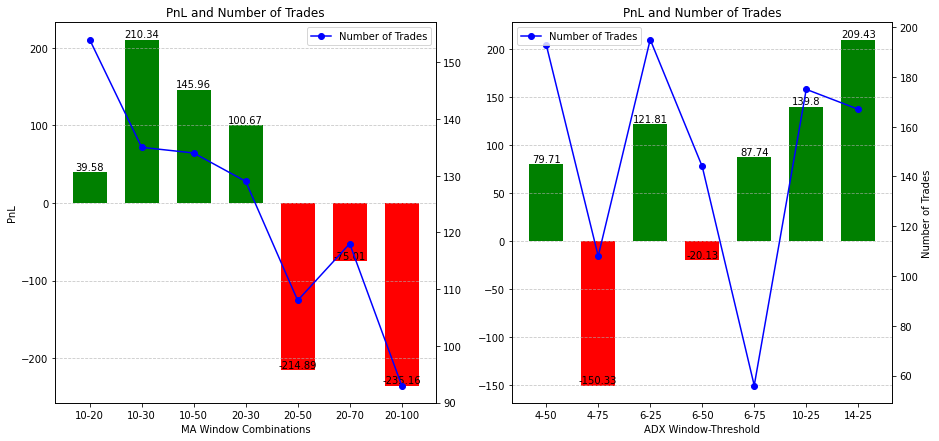

In [20]:
pnl_list = []
no_list = []
pnl_list_adx = []
no_list_adx = []

df = pd.read_csv("MSFT_hist.csv")
df = df[df['Date'] >= '2015-01-01']

portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, short_window=10, long_window=20, stop_loss=0.05, take_profit=0.2)
pnl_list.append(portfolio.iloc[-1]['pnl'])
no_list.append(portfolio.iloc[-1]['no_trades'])
portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, short_window=10, long_window=30, stop_loss=0.05, take_profit=0.2)
pnl_list.append(portfolio.iloc[-1]['pnl'])
no_list.append(portfolio.iloc[-1]['no_trades'])
portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, short_window=10, long_window=50, stop_loss=0.05, take_profit=0.2)
pnl_list.append(portfolio.iloc[-1]['pnl'])
no_list.append(portfolio.iloc[-1]['no_trades'])
portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, short_window=20, long_window=30, stop_loss=0.05, take_profit=0.2)
pnl_list.append(portfolio.iloc[-1]['pnl'])
no_list.append(portfolio.iloc[-1]['no_trades'])
portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, short_window=20, long_window=50, stop_loss=0.05, take_profit=0.2)
pnl_list.append(portfolio.iloc[-1]['pnl'])
no_list.append(portfolio.iloc[-1]['no_trades'])
portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, short_window=20, long_window=70, stop_loss=0.05, take_profit=0.2)
pnl_list.append(portfolio.iloc[-1]['pnl'])
no_list.append(portfolio.iloc[-1]['no_trades'])
portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, short_window=20, long_window=100, stop_loss=0.05, take_profit=0.2)
pnl_list.append(portfolio.iloc[-1]['pnl'])
no_list.append(portfolio.iloc[-1]['no_trades'])

portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, adx_window=4, adx_threshold=50, stop_loss=0.05, take_profit=0.2)
pnl_list_adx.append(portfolio.iloc[-1]['pnl'])
no_list_adx.append(portfolio.iloc[-1]['no_trades'])
portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, adx_window=4, adx_threshold=75, stop_loss=0.05, take_profit=0.2)
pnl_list_adx.append(portfolio.iloc[-1]['pnl'])
no_list_adx.append(portfolio.iloc[-1]['no_trades'])
portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, adx_window=6, adx_threshold=25, stop_loss=0.05, take_profit=0.2)
pnl_list_adx.append(portfolio.iloc[-1]['pnl'])
no_list_adx.append(portfolio.iloc[-1]['no_trades'])
portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, adx_window=6, adx_threshold=50, stop_loss=0.05, take_profit=0.2)
pnl_list_adx.append(portfolio.iloc[-1]['pnl'])
no_list_adx.append(portfolio.iloc[-1]['no_trades'])
portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, adx_window=6, adx_threshold=75, stop_loss=0.05, take_profit=0.2)
pnl_list_adx.append(portfolio.iloc[-1]['pnl'])
no_list_adx.append(portfolio.iloc[-1]['no_trades'])
portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, adx_window=10, adx_threshold=25, stop_loss=0.05, take_profit=0.2)
pnl_list_adx.append(portfolio.iloc[-1]['pnl'])
no_list_adx.append(portfolio.iloc[-1]['no_trades'])
portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, adx_window=14, adx_threshold=25, stop_loss=0.05, take_profit=0.2)
pnl_list_adx.append(portfolio.iloc[-1]['pnl'])
no_list_adx.append(portfolio.iloc[-1]['no_trades'])

loops(loop_one_ma)
loops(loop_one_adx)

fig, axs = plt.subplots(1, 2, figsize=(15, 7))

bar_width = 0.65
index = np.arange(len(pnl_list))
bars1 = axs[0].bar(index, pnl_list, bar_width, color=['green' if pl >= 0 else 'red' for pl in pnl_list], label='PnL')

axs[0].set_xlabel('MA Window Combinations')
axs[0].set_ylabel('PnL')
axs[0].set_title('PnL and Number of Trades')
axs[0].set_xticks(index)
axs[0].set_xticklabels(['10-20', '10-30', '10-50', '20-30', '20-50', '20-70', '20-100'])
axs[0].grid(axis='y', linestyle='--', alpha=0.7)
axs1 = axs[0].twinx()
axs1.plot(index, no_list, color='blue', marker='o', label='Number of Trades')
axs1.legend(loc='upper right')

for i, bar in enumerate(bars1):
        axs[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(round(pnl_list[i], 2)), ha='center', va='bottom')

index = np.arange(len(pnl_list_adx))
bars2 = axs[1].bar(index, pnl_list_adx, bar_width, color=['green' if pl >= 0 else 'red' for pl in pnl_list_adx], label='PnL')

axs[1].set_xlabel('ADX Window-Threshold')
axs[1].set_title('PnL and Number of Trades')
axs[1].set_xticks(index)
axs[1].set_xticklabels(['4-50', '4-75', '6-25', '6-50', '6-75', '10-25', '14-25'])
axs[1].grid(axis='y', linestyle='--', alpha=0.7)
axs2 = axs[1].twinx()
axs2.plot(index, no_list_adx, color='blue', marker='o', label='Number of Trades')
axs2.set_ylabel('Number of Trades')
axs2.legend(loc='upper left')

for i, bar in enumerate(bars2):
        axs[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(round(pnl_list_adx[i], 2)), ha='center', va='bottom')
        
    
plt.show()

In [21]:
def loop_rsi(df):
    n=0
    for take_profit in take_profit_values:
        portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=70, overbought_threshold=90, oversold_threshold=60, stop_loss=0.05, take_profit=take_profit)
        pnl_list_rsi[n] = pnl_list_rsi[n] + portfolio.iloc[-1]['pnl']
        n+=1
        
def loop_adx(df):
    n=0
    for take_profit in take_profit_values:
        portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, adx_window=14, adx_threshold=25, stop_loss=0.05, take_profit=take_profit)
        pnl_list_adx[n] = pnl_list_adx[n] + portfolio.iloc[-1]['pnl']
        n+=1
        
def loop_ma(df):
    n=0
    for take_profit in take_profit_values:
        portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, short_window=10, long_window=30, stop_loss=0.05, take_profit=take_profit)
        pnl_list_ma[n] = pnl_list_ma[n] + portfolio.iloc[-1]['pnl']
        n+=1
        
def loop_complete(df):
    n=0
    for take_profit in take_profit_values:
        portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, complete=True, short_window=5, long_window=10, adx_window=14, adx_threshold=25, rsi_window=70, overbought_threshold=70, oversold_threshold=60, stop_loss=0.05, take_profit=take_profit)
        pnl_list_complete[n] = pnl_list_complete[n] + portfolio.iloc[-1]['pnl']
        n+=1

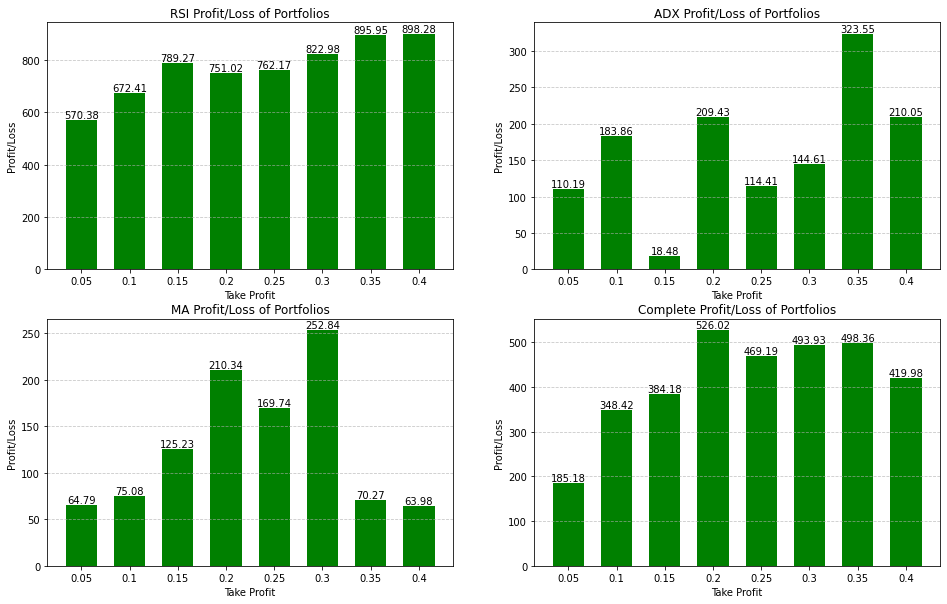

In [22]:
# May take a while to run as have to loop through all datasets for all strategies

take_profit_values = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
pnl_list_rsi = []
pnl_list_adx = []
pnl_list_ma = []
pnl_list_complete = []

df = pd.read_csv("MSFT_hist.csv")
df = df[df['Date'] >= '2015-01-01']

for take_profit in take_profit_values:
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, rsi_window=70, overbought_threshold=90, oversold_threshold=60, stop_loss=0.05, take_profit=take_profit)
    pnl_list_rsi.append(portfolio.iloc[-1]['pnl'])
    
for take_profit in take_profit_values:
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, adx_window=14, adx_threshold=25, stop_loss=0.05, take_profit=take_profit)
    pnl_list_adx.append(portfolio.iloc[-1]['pnl'])
    
for take_profit in take_profit_values:
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, short_window=10, long_window=30, stop_loss=0.05, take_profit=take_profit)
    pnl_list_ma.append(portfolio.iloc[-1]['pnl'])
    
for take_profit in take_profit_values:
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, complete=True, short_window=5, long_window=10, adx_window=14, adx_threshold=25, rsi_window=70, overbought_threshold=70, oversold_threshold=60, stop_loss=0.05, take_profit=take_profit)
    pnl_list_complete.append(portfolio.iloc[-1]['pnl'])
    
loops(loop_rsi)
loops(loop_adx)
loops(loop_ma)
loops(loop_complete)

def plot_profit_loss(ax, pnl_list, take_profit_values, strategy_name):
    bar_width = 0.65
    index = np.arange(len(take_profit_values))
    bars = ax.bar(index, pnl_list, bar_width, color=['green' if pl >= 0 else 'red' for pl in pnl_list])

    ax.set_xlabel('Take Profit')
    ax.set_ylabel('Profit/Loss')
    ax.set_title(f'{strategy_name} Profit/Loss of Portfolios')
    ax.set_xticks(index)
    ax.set_xticklabels(take_profit_values)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Display values on top of bars
    for i, bar in enumerate(bars):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(round(pnl_list[i], 2)), ha='center', va='bottom')

    
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
    
plot_profit_loss(axs[0, 0], pnl_list_rsi, take_profit_values, 'RSI')
plot_profit_loss(axs[0, 1], pnl_list_adx, take_profit_values, 'ADX')
plot_profit_loss(axs[1, 0], pnl_list_ma, take_profit_values, 'MA')
plot_profit_loss(axs[1, 1], pnl_list_complete, take_profit_values, 'Complete')

In [27]:
def complete_loop(df):
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, complete=True, short_window=5, long_window=10, adx_window=14, adx_threshold=25, rsi_window=70, overbought_threshold=70, oversold_threshold=60, stop_loss=0.05, take_profit=0.2)
    total_pnl[0] = total_pnl[0] + portfolio.iloc[-1]['pnl']
    total_no_trades[0] = total_no_trades[0] + portfolio.iloc[-1]['no_trades']
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, complete=True, short_window=10, long_window=30, adx_window=22, adx_threshold=25, rsi_window=70, overbought_threshold=80, oversold_threshold=60, stop_loss=0.05, take_profit=0.2)
    total_pnl[1] = total_pnl[1] + portfolio.iloc[-1]['pnl']
    total_no_trades[1] = total_no_trades[1] + portfolio.iloc[-1]['no_trades']
    portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, complete=True, short_window=10, long_window=30, adx_window=30, adx_threshold=25, rsi_window=70, overbought_threshold=80, oversold_threshold=50, stop_loss=0.05, take_profit=0.2)
    total_pnl[2] = total_pnl[2] + portfolio.iloc[-1]['pnl']
    total_no_trades[2] = total_no_trades[2] + portfolio.iloc[-1]['no_trades']

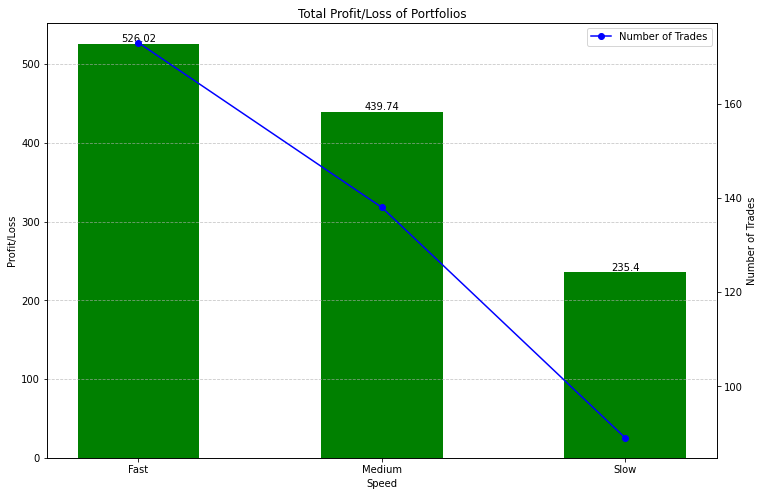

In [28]:
total_pnl=[]
total_no_trades=[]


df = pd.read_csv("MSFT_hist.csv")
df = df[df['Date'] >= '2015-01-01']

portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, complete=True, short_window=5, long_window=10, adx_window=14, adx_threshold=25, rsi_window=70, overbought_threshold=70, oversold_threshold=60, stop_loss=0.05, take_profit=0.2)
total_pnl.append(portfolio.iloc[-1]['pnl'])
total_no_trades.append(portfolio.iloc[-1]['no_trades'])
portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, complete=True, short_window=10, long_window=30, adx_window=22, adx_threshold=25, rsi_window=70, overbought_threshold=80, oversold_threshold=60, stop_loss=0.05, take_profit=0.2)
total_pnl.append(portfolio.iloc[-1]['pnl'])
total_no_trades.append(portfolio.iloc[-1]['no_trades'])
portfolio = backtest_strategy(df, initial_cash=100, transaction_cost=0, complete=True, short_window=10, long_window=30, adx_window=30, adx_threshold=25, rsi_window=70, overbought_threshold=80, oversold_threshold=50, stop_loss=0.05, take_profit=0.2)
total_pnl.append(portfolio.iloc[-1]['pnl'])
total_no_trades.append(portfolio.iloc[-1]['no_trades'])

df = pd.read_csv("AAPL_hist.csv")
df = df[df['Date'] >= '2015-01-01']
complete_loop(df)
df = pd.read_csv("JPM_hist.csv")
df = df[df['Date'] >= '2015-01-01']
complete_loop(df)
df = pd.read_csv("BAC_hist.csv")
df = df[df['Date'] >= '2015-01-01']
complete_loop(df)
df = pd.read_csv("PFE_hist.csv")
df = df[df['Date'] >= '2015-01-01']
complete_loop(df)
df = pd.read_csv("JNJ_hist.csv")
df = df[df['Date'] >= '2015-01-01']
complete_loop(df)

fig, ax = plt.subplots(figsize=(12, 8))

# Create bars for each value
bar_width = 0.5
index = np.arange(len(total_pnl))
bars = ax.bar(index, total_pnl, bar_width, color=['green' if pl >= 0 else 'red' for pl in total_pnl])

# Add labels, title, and grid
ax.set_xlabel('Speed')
ax.set_ylabel('Profit/Loss')
ax.set_title('Total Profit/Loss of Portfolios')
ax.set_xticks(index)
ax.set_xticklabels(['Fast', 'Medium', 'Slow'])
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax1 = ax.twinx()
ax1.plot(index, total_no_trades, color='blue', marker='o', label='Number of Trades')
ax1.set_ylabel('Number of Trades')
ax1.legend(loc='upper right')

# Display values on top of bars
for i, bar in enumerate(bars):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(round(total_pnl[i],2)), ha='center', va='bottom')
plt.show()